# 3D Segmentation of MRI Brain Images
---
Author: Isaac Lam

## Introduction
In this project, our objective is to carry out the segmentation of 3D MRI brain images. The main goal is to develop a model that can accurately detect the precise locations of tumors, necrotic areas, and peritumoral edematous tissue. Accurate segmentation of these structures provide detailed information on their size, shape and location. This information can aid medical professionals in planning interventions more effectively and minimize damage to healthy tissue. Moreover, segmentation also facilitates quantitative analysis, enabling measurements of specific structures' volumes. Tracking changes in these measurements over time can provide valuable insights into the progression of diseases and the effectiveness of treatments. In the context of clinical trials for novel therapies, precise segmentation of brain tumors and tissue empowers researchers to evaluate treatment efficacy and potential side effects with greater accuracy.

## About the BraTs2021 Dataset

This [dataset](https://www.kaggle.com/datasets/dschettler8845/brats-2021-task1) consists of MRI brain images in NIfTI file format (.nii.gz) and encompass the following components: a) native (T1), b) post-contrast T1-weighted (T1Gd), c) T2-weighted (T2), and d) T2 Fluid Attenuated Inversion Recovery (T2-FLAIR) volumes. These scans were obtained using diverse clinical procedures and a variety of scanners from multiple institutions contributing data.

All the image datasets have undergone manual annotation by one to four raters, adhering to a consistent annotation protocol. The annotations were reviewed and endorsed by experienced neuro-radiologists. The annotations include three categories: the GD-enhancing tumor (ET — label 4), the peritumoral edematous/invaded tissue (ED — label 2), and the necrotic tumor core (NCR — label 1), as detailed in the most recent BraTS summary publication [(U.Baid et al., 2021)](https://arxiv.org/abs/2107.02314v2). The ground truth data were established subsequent to preprocessing, involving co-registration to a common anatomical template, interpolation to uniform resolution (1 mm3), and skull-stripping.

---
## Loading and Visualizing the Dataset
### Load the Data

In [ ]:
#set directories
import os
dataset_dir = r'C:\Users\isaac\OneDrive\Documents\Projects\datasets\BraTs2021'
save_dir = r'C:\Users\isaac\OneDrive\Documents\Projects\Saved'
os.mkdir(os.path.join(save_dir, 'brats_files'))
brats_files_path = os.path.join(save_dir, 'brats_files')
os.listdir(dataset_dir)

#open files
'''
import tarfile
files = tarfile.open(os.path.join(dataset_dir, 'BraTs2021_Training_Data.tar'))
files.extractall(path = brats_files_path)
'''

In [ ]:
brats_files = os.listdir(brats_files_path)
print(f'number of MRI images: {len(brats_files)}') #number of MRI images
print(brats_files[:5]) #list the first 5 files

#explore image formats in each file
import random
os.listdir(os.path.join(brats_files_path, brats_files[random.randint(0, 1252)]))

We observe that each image file consists of 5 distinct image formats. Moreover, there is a redundant file '.DS_Store' which will be removed.

In [ ]:
#delete unncessary file
os.remove(os.path.join(brats_files_path, '.DS_Store'))
brats_files = os.listdir(brats_files_path)
print(f'number of MRI images: {len(brats_files)}') #recheck number of images after deleting

This dataset is of considerable size and demands substantial computational resources for storage and training. To fulfill the requirements of this project, we will select images at random to constitute a subset for inclusion. We do this by defining a function that randomly eliminates images until the desired quantity of images is reached.

In [ ]:
'''
#random sampling of images
import shutil
import random

def random_sample(files_path, number):
  image_files = os.listdir(files_path)
  if len(image_files) > number:
    del_count =1
    while len(image_files) > number:
      shutil.rmtree(os.path.join(files_path, image_files[random.randint(0, len(image_files)-1)]))
      del_count +=1
      image_files = os.listdir(files_path)
    
    print(f'total number of files deleted: {del_count}')
    print(f'number of MRI images remaining after random sampling: {len(image_files)}')
  else:
    print('Number of image files is less than or equal to the specified number.')
    
random_sample(brats_files_path, _)

brats_files = os.listdir(brats_files_path)
'''

### Data Visualization
3D medical images can be viewed from multiple angles. Conventionally, they are examined using cross-sectional perspectives within the axial, coronal, and sagittal planes. To obtain a comprehensive understanding of our brain images, we will visualize them within these three planes.

#### Load a random image to visualize

In [3]:
import nibabel as nib
import random

#define a function to sample random images
def load_sample_img(file_name = brats_files[random.randint(0, len(brats_files))]):
  image_t1_path = os.path.join(brats_files_path, file_name, file_name + '_t1.nii.gz')
  image_t1ce_path = os.path.join(brats_files_path, file_name, file_name + '_t1ce.nii.gz')
  image_t2_path = os.path.join(brats_files_path, file_name, file_name + '_t2.nii.gz')
  image_flair_path = os.path.join(brats_files_path, file_name, file_name + '_flair.nii.gz')
  image_seg_path = os.path.join(brats_files_path, file_name, file_name + '_seg.nii.gz') 
  
  image_t1 = nib.load(image_t1_path).get_fdata()
  image_t1ce = nib.load(image_t1ce_path).get_fdata()
  image_t2 = nib.load(image_t2_path).get_fdata()
  image_flair = nib.load(image_flair_path).get_fdata()
  image_seg = nib.load(image_seg_path).get_fdata()
  
  print('===info===')
  print(f't1: {image_t1.shape}')
  print(f't1ce: {image_t1ce.shape}')
  print(f't2: {image_t2.shape}')
  print(f'flair: {image_flair.shape}')
  print(f'seg: {image_seg.shape}')
  print(f'file_name = {file_name}')
  
  return image_t1_path, image_t1ce_path, image_t2_path, image_flair_path, image_seg_path, image_t1, image_t1ce, image_t2, image_flair, image_seg

image_t1_path, image_t1ce_path, image_t2_path, image_flair_path, image_seg_path, image_t1, image_t1ce, image_t2, image_flair, image_seg = load_sample_img()

===info===
t1: (240, 240, 155)
t1ce: (240, 240, 155)
t2: (240, 240, 155)
flair: (240, 240, 155)
seg: (240, 240, 155)
file_name = BraTS2021_01037


#### Region of Interest Plot

label 0.0: 8798962
label 1.0: 26333
label 2.0: 88850
label 4.0: 13855


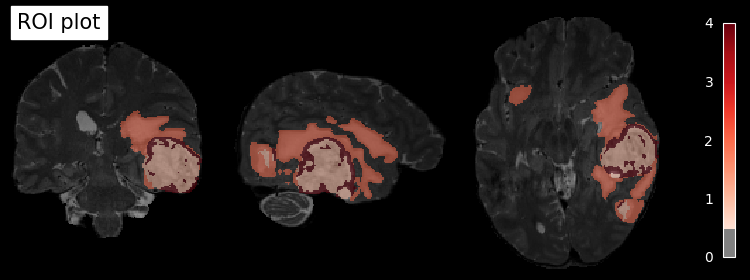

In [4]:
#count values in image_seg
import matplotlib.pyplot as plt
from scipy import ndimage
import numpy as np

unique, counts = np.unique(image_seg, return_counts = True)
for label, value in zip(unique, counts):
  print(f'label {label}: {value}')
  
#orthogonal cuts highlighting regions of interest
from nilearn import plotting
from nilearn.plotting import plot_roi


plt.close()
plot_roi(image_seg_path, image_t2_path, title = 'ROI plot', cmap = 'Reds', alpha = 0.5, annotate = False, draw_cross = False, colorbar = True, vmin = 0)
plt.show()

#### Define a function to plot midslice MRI images

<Figure size 1200x1200 with 0 Axes>

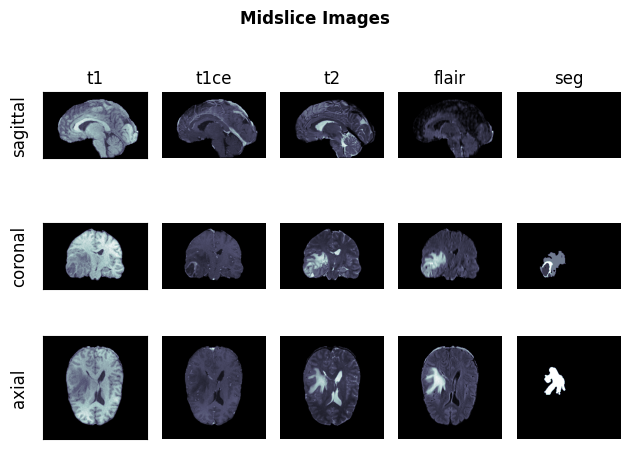

In [5]:
#define a function to plot midslice MRI images
def plot_mri(image_t1, image_t1ce, image_t2, image_flair, image_seg):
  plt.close()
  plt.figure(figsize = (12,12))
  fig, axes = plt.subplots(3,5)

  #t1
  axes[0,0].imshow(ndimage.rotate(image_t1[image_t1.shape[0]//2,:,:], 90), cmap = 'bone')
  axes[0,0].grid(False)
  axes[1,0].imshow(ndimage.rotate(image_t1[:,image_t1.shape[1]//2,:], 90), cmap = 'bone')
  axes[1,0].grid(False)
  axes[2,0].imshow(ndimage.rotate(image_t1[:,:,image_t1.shape[2]//2], 90), cmap = 'bone')
  axes[2,0].grid(False)
  
  #t1ce
  axes[0,1].imshow(ndimage.rotate(image_t1ce[image_t1ce.shape[0]//2,:,:], 90), cmap = 'bone')
  axes[0,1].axis('off')
  axes[1,1].imshow(ndimage.rotate(image_t1ce[:,image_t1ce.shape[1]//2,:], 90), cmap = 'bone')
  axes[1,1].axis('off')
  axes[2,1].imshow(ndimage.rotate(image_t1ce[:,:,image_t1ce.shape[2]//2], 90), cmap = 'bone')
  axes[2,1].axis('off')
  
  #t2
  axes[0,2].imshow(ndimage.rotate(image_t2[image_t2.shape[0]//2,:,:], 90), cmap = 'bone')
  axes[0,2].axis('off')
  axes[1,2].imshow(ndimage.rotate(image_t2[:,image_t2.shape[1]//2,:], 90), cmap = 'bone')
  axes[1,2].axis('off')
  axes[2,2].imshow(ndimage.rotate(image_t2[:,:,image_t2.shape[2]//2], 90), cmap = 'bone')
  axes[2,2].axis('off')
  
  #flair
  axes[0,3].imshow(ndimage.rotate(image_flair[image_flair.shape[0]//2,:,:], 90), cmap = 'bone')
  axes[0,3].axis('off')
  axes[1,3].imshow(ndimage.rotate(image_flair[:,image_flair.shape[1]//2,:], 90), cmap = 'bone')
  axes[1,3].axis('off')
  axes[2,3].imshow(ndimage.rotate(image_flair[:,:,image_flair.shape[2]//2], 90), cmap = 'bone')
  axes[2,3].axis('off')
  
  #seg
  axes[0,4].imshow(ndimage.rotate(image_seg[image_seg.shape[0]//2,:,:], 90), cmap = 'bone')
  axes[0,4].axis('off')
  axes[1,4].imshow(ndimage.rotate(image_seg[:,image_seg.shape[1]//2,:], 90), cmap = 'bone')
  axes[1,4].axis('off')
  axes[2,4].imshow(ndimage.rotate(image_seg[:,:,image_seg.shape[2]//2], 90), cmap = 'bone')
  axes[2,4].axis('off')
  
  #col and row labels
  cols = ['t1', 't1ce', 't2', 'flair', 'seg']
  rows = ['sagittal', 'coronal', 'axial']
  
  for ax, col in zip(axes[0], cols):
    ax.set_title(col)
    
  for ax, row in zip(axes[:,0], rows):
    ax.tick_params(left = False, bottom = False)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.set_ylabel(row, rotation=90, size = 'large')
  
  fig.suptitle('Midslice Images', fontweight = 'bold')
  fig.tight_layout()
  plt.show()

plot_mri(image_t1, image_t1ce, image_t2, image_flair, image_seg)

The masks shown in the annotations accurately match the brain lesions depicted in the MRI images.

#### Interactive 3D plots of Brain MRI

In [6]:
from ipywidgets import interact
import ipywidgets as widgets
def sagittal_slider(layer):
    plt.figure(figsize = (4, 4))
    plt.imshow(ndimage.rotate(image_t1[layer, :, :], 90), cmap = 'bone')
    plt.axis('off')
    plt.title('sagittal')

def coronal_slider(layer):
    plt.figure(figsize = (4, 4))
    plt.imshow(ndimage.rotate(image_t1[:, layer, :], 90), cmap = 'bone')
    plt.axis('off')
    plt.title('coronal')

def axial_slider(layer):
    plt.figure(figsize = (4, 4))
    plt.imshow(ndimage.rotate(image_t1[:, :, layer], 90), cmap = 'bone')
    plt.axis('off')
    plt.title('axial')
    
interact(sagittal_slider, layer = (0, image_t1.shape[0]-1))
interact(coronal_slider, layer = (0, image_t1.shape[1]-1))
interact(axial_slider, layer = (0, image_t1.shape[2]-1))


interactive(children=(IntSlider(value=119, description='layer', max=239), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=119, description='layer', max=239), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=77, description='layer', max=154), Output()), _dom_classes=('widget-inte…

<function __main__.axial_slider(layer)>

---

## Data preprocessing
Previously, we noted that every MRI image has dimensions of (240, 240, 155). Furthermore, to enhance our model's understanding, we intend to merge various image formats into a substantial composite image of four channels, leading to a significant increase in image size. Unfortunately, due to this augmentation, the computer's memory capacity becomes inadequate for utilizing images of this magnitude as inputs for our model. Nonetheless, it remains crucial to preserve the inherent dimensions of our images to ensure our model retains contextual awareness of the neighboring voxels. 

To overcome the constraints imposed by the computer's memory capacity, we will adopt a patch-based strategy for performing image segmentation in this task. The input dimensions will be adjusted to (128, 128, 128). 

### Train Test Split

In [7]:
#create list of brats files
import os

#train test split
from sklearn.model_selection import train_test_split
train_val, test = train_test_split(brats_files, test_size = 100, random_state = 123)
train, val = train_test_split(train_val, test_size = 150, random_state = 123)

#check size of split
print(f'Training size: {len(train)}')
print(f'Validation size: {len(val)}')
print(f'Testing size {len(test)}')

Training size: 1001
Validation size: 150
Testing size 100


### Create and Save Directory Paths

In [ ]:
#define directory of saved files
os.mkdir(os.path.join(save_dir, 'brats_saved'))

os.mkdir(os.path.join(brats_saved, 'train_x'))
os.mkdir(os.path.join(brats_saved, 'train_y'))
os.mkdir(os.path.join(brats_saved, 'val_x'))
os.mkdir(os.path.join(brats_saved, 'val_y'))
os.mkdir(os.path.join(brats_saved, 'test_x'))
os.mkdir(os.path.join(brats_saved, 'test_y'))

In [9]:
#define x and y paths
brats_saved = os.path.join(save_dir, 'brats_saved')
train_x_path = os.path.join(brats_saved, 'train_x') 
train_y_path = os.path.join(brats_saved, 'train_y')
val_x_path = os.path.join(brats_saved, 'val_x')
val_y_path = os.path.join(brats_saved, 'val_y')
test_x_path = os.path.join(brats_saved, 'test_x')
test_y_path = os.path.join(brats_saved, 'test_y')

In the subsequent code excerpt, we combined the t1, t1ce, t2, and flair MRI formats to form the four channels of each image. This produces images of dimensions (240, 240, 155, 4). Additionally, annotations underwent one-hot encoding, aligning them with their corresponding classes. Finally, the images were saved in the numpy format.

### Create Training and Validation Patches

In [10]:
#load 
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

def create_patches(num, save, orig_dims = (240, 240, 155), output_dims = (128, 128, 128), threshold = 0.99, max_tries = 1000, train_x_path = train_x_path, train_y_path = train_y_path):
  scaler = MinMaxScaler()
  counter = 0
  for i in save:
    temp_seg = nib.load(os.path.join(brats_files_path, i, i + '_seg.nii.gz')).get_fdata()
    temp_seg[temp_seg == 4] = 3 #relabel 4 to 3
    temp_seg = tf.keras.utils.to_categorical(temp_seg, num_classes = 4)
    
    tries = 0
    
    while tries < max_tries:
      # increase tries counter
      tries += 1
      
      # define starting points for random crop
      start_x = np.random.randint(0, orig_dims[0] - output_dims[0] + 1)
      start_y = np.random.randint(0, orig_dims[1] - output_dims[1] + 1)
      start_z = np.random.randint(0, orig_dims[2] - output_dims[2] + 1)
      
      temp_seg_patch = temp_seg[start_x: start_x + output_dims[0], start_y: start_y + output_dims[1], start_z: start_z + output_dims[2], :]
      
      # save crop if void region < threshold
      if np.sum(temp_seg_patch[:,:,:,0])/(output_dims[0]*output_dims[1]*output_dims[2]) < threshold: 
        counter += 1
        # save y patch
        if save == train:
          np.save(os.path.join(train_y_path, f'train_y_{counter:04d}_{num}'), temp_seg_patch)
          
        elif save == val:
          np.save(os.path.join(val_y_path, f'val_y_{counter:04d}_{num}'), temp_seg_patch)
          
        else:
          print('Unable to save seg patch. please input save = train or val')
        
        # extract images of each format and perform min max scaling
        temp_t1 = nib.load(os.path.join(brats_files_path, i, i + '_t1.nii.gz')).get_fdata()
        temp_t1 = scaler.fit_transform(temp_t1.reshape(-1, 1)).reshape(temp_t1.shape) #min max scale
        
        temp_t1ce = nib.load(os.path.join(brats_files_path, i, i + '_t1ce.nii.gz')).get_fdata()
        temp_t1ce = scaler.fit_transform(temp_t1ce.reshape(-1, 1)).reshape(temp_t1ce.shape) #min max scale
        
        temp_t2 = nib.load(os.path.join(brats_files_path, i, i + '_t2.nii.gz')).get_fdata()
        temp_t2 = scaler.fit_transform(temp_t2.reshape(-1, 1)).reshape(temp_t2.shape) #min max scale
        
        temp_flair = nib.load(os.path.join(brats_files_path, i, i + '_flair.nii.gz')).get_fdata()
        temp_flair = scaler.fit_transform(temp_flair.reshape(-1, 1)).reshape(temp_flair.shape) #min max scale
        
        # stack image formats as 4 channels
        temp_combined = np.stack([temp_t1, temp_t1ce, temp_t2, temp_flair], axis = 3)  
        
        # crop x patch
        temp_combined_patch = temp_combined[start_x: start_x + output_dims[0], start_y: start_y + output_dims[1], start_z: start_z + output_dims[2]]

        # save x patch
        if save == train:
          np.save(os.path.join(train_x_path, f'train_x_{counter:04d}_{num}'), temp_combined_patch)
          
        elif save == val:
          np.save(os.path.join(val_x_path, f'val_x_{counter:04d}_{num}'), temp_combined_patch)
          
        else:
          print('Unable to save image patch. Please input save = train or val')
        
        break
    

In [137]:
create_patches(1, train)
create_patches(1, val)

A plot of the loaded images confirms that the images have been correctly stored and reloaded.

number of x train images: 928
number of y train images: 928
number of x val images: 142
number of val y images: 142
(128, 128, 128, 4)
(128, 128, 128, 4)


<Figure size 1200x1200 with 0 Axes>

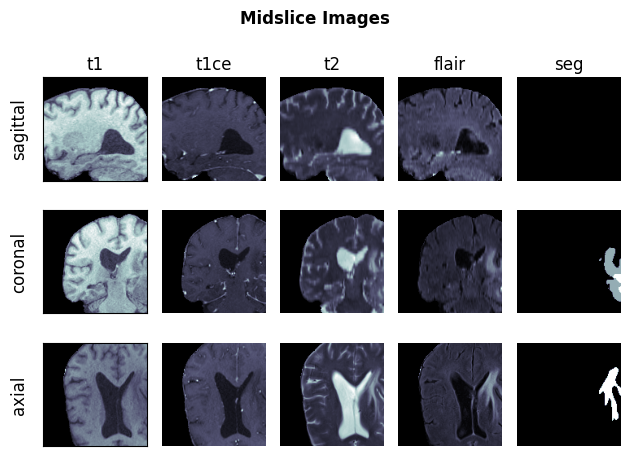

In [12]:
#load sample of saved images
train_x = os.listdir(train_x_path)
train_y = os.listdir(train_y_path)
print(f'number of x train images: {len(train_x)}')
print(f'number of y train images: {len(train_y)}')
print(f'number of x val images: {len(os.listdir(val_x_path))}')
print(f'number of val y images: {len(os.listdir(val_y_path))}')

random_train_idx = np.random.randint(0, len(train_x))
image_loaded = np.load(os.path.join(train_x_path, train_x[random_train_idx]))
print(image_loaded.shape)

image_t1_loaded = image_loaded[:,:,:,0]
image_t1ce_loaded = image_loaded[:,:,:,1]
image_t2_loaded = image_loaded[:,:,:,2]
image_flair_loaded = image_loaded[:,:,:,3]

image_seg_loaded = np.load(os.path.join(train_y_path, train_y[random_train_idx]))
print(image_seg_loaded.shape)
image_seg_loaded = np.argmax(image_seg_loaded, axis = 3) #reverse to pre-one-hot encoded form

#visual verification of loaded images
plot_mri(image_t1_loaded, image_t1ce_loaded, image_t2_loaded, image_flair_loaded, image_seg_loaded)

### Create Testing Patches

During the testing phase, we will merge all patches to reconstruct the whole image.
The following code snippet defines a function that extracts patches of our desired patch size in a sliding window fashion, such that every voxel of the image is extracted.
The patches will be reassembled such that some voxels overlap. 
Importantly, we will extract patches from all corners of the image, patches near the center, and a central cropped patch from the entire image. This strategy empowers our model to make predictions using contextual information from various regions of the complete image in the testing phase.

In [41]:
def create_test_patches(orig_dims = (240, 240, 155), output_dims = (128, 128, 128), steps = (112, 112, 27), inner_steps = (56, 56, 15)):
    import math
    scaler = MinMaxScaler()
    
    lenx = output_dims[0]
    leny = output_dims[1]
    lenz = output_dims[2]
    
    for i, img in enumerate(test):
        temp_seg = nib.load(os.path.join(brats_files_path, img, img + '_seg.nii.gz')).get_fdata()
        temp_seg[temp_seg == 4] = 3 #relabel 4 to 3
        temp_seg = tf.keras.utils.to_categorical(temp_seg, num_classes = 4) #one hot encode
        
        #save whole image
        np.save(os.path.join(test_y_path, f'test_y_{i:02d}'), temp_seg)
        
        #test_x
        # Create directory for every test file
        os.mkdir(os.path.join(test_x_path, f'test_x_{i:02d}'))
        
        # extract images of each format and perform min max scaling
        temp_t1 = nib.load(os.path.join(brats_files_path, img, img + '_t1.nii.gz')).get_fdata()
        temp_t1 = scaler.fit_transform(temp_t1.reshape(-1, 1)).reshape(temp_t1.shape) #min max scale
        
        temp_t1ce = nib.load(os.path.join(brats_files_path, img, img + '_t1ce.nii.gz')).get_fdata()
        temp_t1ce = scaler.fit_transform(temp_t1ce.reshape(-1, 1)).reshape(temp_t1ce.shape) #min max scale
        
        temp_t2 = nib.load(os.path.join(brats_files_path, img, img + '_t2.nii.gz')).get_fdata()
        temp_t2 = scaler.fit_transform(temp_t2.reshape(-1, 1)).reshape(temp_t2.shape) #min max scale
        
        temp_flair = nib.load(os.path.join(brats_files_path, img, img + '_flair.nii.gz')).get_fdata()
        temp_flair = scaler.fit_transform(temp_flair.reshape(-1, 1)).reshape(temp_flair.shape) #min max scale
        
        # stack image formats as 4 channels
        temp_combined = np.stack([temp_t1, temp_t1ce, temp_t2, temp_flair], axis = 3)  
        
        for a, x in enumerate(range(0, orig_dims[0] - lenx + 1, steps[0])): 
            for b, y in enumerate(range(0, orig_dims[1] - leny + 1, steps[1])): 
                for c, z in enumerate(range(0, orig_dims[2] - lenz + 1, steps[2])): 
                    test_x = temp_combined[x: x + lenx, y: y + leny, z: z + lenz, :]
                    np.save(os.path.join(test_x_path, f'test_x_{i:02d}', f'test_x_{i:02d}_{a}{b}{c}'), test_x)
        
        # create inner patches
        inner_width_start = int((orig_dims[0] - output_dims[0])/4)
        inner_width_end = orig_dims[0] - inner_width_start
        inner_height_start = (orig_dims[2] - output_dims[2])//4
        inner_height_end = orig_dims[2] - inner_height_start
        for a, x in enumerate(range(inner_width_start -1, inner_width_end - lenx + 1, inner_steps[0])): 
            for b, y in enumerate(range(inner_width_start -1, inner_width_end - leny + 1, inner_steps[1])): 
                for c, z in enumerate(range(inner_height_start -1, inner_height_end - lenz + 1, inner_steps[2])): 
                    test_x = temp_combined[x: x + lenx, y: y + leny, z: z + lenz, :]
                    np.save(os.path.join(test_x_path, f'test_x_{i:02d}', f'test_x_{i:02d}_inner{a}{b}{c}'), test_x)
                    
        # create mid patch            
        mid_width_start = int((orig_dims[0] - output_dims[0])/2 -1)
        mid_height_start = math.ceil((orig_dims[2] - output_dims[2])/2) -1
        test_x_mid = temp_combined[mid_width_start: mid_width_start + output_dims[0], 
                                   mid_width_start: mid_width_start + output_dims[1], 
                                   mid_height_start: mid_height_start + output_dims[2]]
        np.save(os.path.join(test_x_path, f'test_x_{i:02d}', f'test_x_{i:02d}_mid'), test_x_mid)
        

In [42]:
create_test_patches()

### Visualize Sample of Test Image

In [43]:
#load sample of saved images
test_x = os.listdir(test_x_path)
test_y = os.listdir(test_y_path)

random_test_idx = np.random.randint(0, len(test_x))
print(f'number of test x images: {len(test_x)}')
print((f'number of test y images: {len(test_y)}'))
print(f'number of patches in a random test x image folder: {len(os.listdir(os.path.join(test_x_path, test_x[random_test_idx])))}') # expect 17 patches per image



number of test x images: 100
number of test y images: 100
number of patches in a random test x image folder: 17


<Figure size 1200x1200 with 0 Axes>

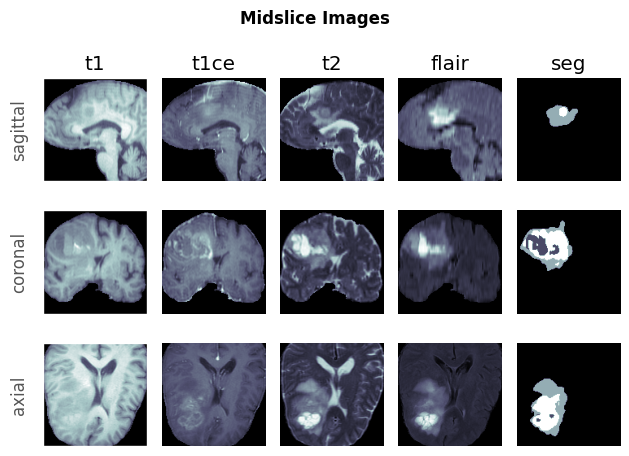

In [44]:
import math
mid_test_image = np.load(os.path.join(test_x_path, os.listdir(test_x_path)[random_test_idx], f'test_x_{random_test_idx:02d}_mid.npy'))

#split image into individual channels for vizualization
mid_test_t1 = mid_test_image[:,:,:,0]
mid_test_t1ce = mid_test_image[:,:,:,1]
mid_test_t2 = mid_test_image[:,:,:,2]
mid_test_flair = mid_test_image[:,:,:,3]

#define dims
orig_dims = (240, 240, 155)
output_dims = (128, 128, 128)

#define starting points for crop
mid_width_start = int((orig_dims[0] - output_dims[0])/2 -1)
mid_height_start = math.ceil((orig_dims[2] - output_dims[2])/2) -1

# load mask
mid_test_seg = np.load(os.path.join(test_y_path, f'test_y_{random_test_idx:02d}.npy'))
mid_test_seg = np.argmax(mid_test_seg, axis = 3) #reverse to pre-one-hot encoded form
mid_test_seg = mid_test_seg[mid_width_start: mid_width_start + output_dims[0], 
                            mid_width_start: mid_width_start + output_dims[1], 
                            mid_height_start: mid_height_start + output_dims[2]]


plot_mri(mid_test_t1, mid_test_t1ce, mid_test_t2, mid_test_flair, mid_test_seg)

### Define Data Generator for Input in Deeplearning Model

Due to the size of our dataset, it is necessary to use a data generator. Generators enable us to load data on-the-fly, batch by batch. This is crucial because the dataset will not fit entirely into memory. Generators maintain a low memory footprint since they only load the current batch into memory. Moreover, to optimize the utilization of computational resources and improve the overall efficiency of the training process, we can use prefetch.

> dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

When we prefetch data, we're essentially instructing the framework to start loading the next batch of data while the current batch is being processed by the model. This overlapping of data loading and model execution helps to minimize the idle time of the model, as it can continue processing data without waiting for the next batch to be fully loaded.

In [16]:
#define custom data generators
def train_generator():
    image_list_x = os.listdir(train_x_path)
    image_list_y = os.listdir(train_y_path)
    while True:
        for image in zip(image_list_x, image_list_y):
            x = np.load(os.path.join(train_x_path, image[0]))
            y = np.load(os.path.join(train_y_path, image[1])) 
            yield(x, y) 
        
def val_generator():
    image_list_x = os.listdir(val_x_path)
    image_list_y = os.listdir(val_y_path)
    while True:
        for image in zip(image_list_x, image_list_y):
            x = np.load(os.path.join(val_x_path, image[0]))
            y = np.load(os.path.join(val_y_path, image[1])) 
            yield(x, y) 

In [17]:
import tensorflow as tf
batch_size = 4
#create generator for training images
train_gen = tf.data.Dataset.from_generator(train_generator, 
                                           output_signature = (tf.TensorSpec(shape = (128, 128, 128, 4)),
                                                               tf.TensorSpec(shape = (128, 128, 128, 4))))
train_gen = train_gen.batch(batch_size).prefetch(tf.data.AUTOTUNE) #prefetch

#create generator for validation images
val_gen = tf.data.Dataset.from_generator(val_generator, 
                                         output_signature = (tf.TensorSpec(shape = (128, 128, 128, 4)),
                                                             tf.TensorSpec(shape = (128, 128, 128, 4))))
val_gen = val_gen.batch(batch_size).prefetch(tf.data.AUTOTUNE) #prefetch

In [18]:
#verify that generator works as expected
print(np.array(next(iter(train_gen))[0]).shape) # train x
print(np.array(next(iter(train_gen))[1]).shape) # train y

print(np.array(next(iter(val_gen))[0]).shape) # val x
print(np.array(next(iter(val_gen))[1]).shape) # val y

(4, 128, 128, 128, 4)
(4, 128, 128, 128, 4)
(4, 128, 128, 128, 4)
(4, 128, 128, 128, 4)


### Visualize Patches from Data Generator

<Figure size 1200x1200 with 0 Axes>

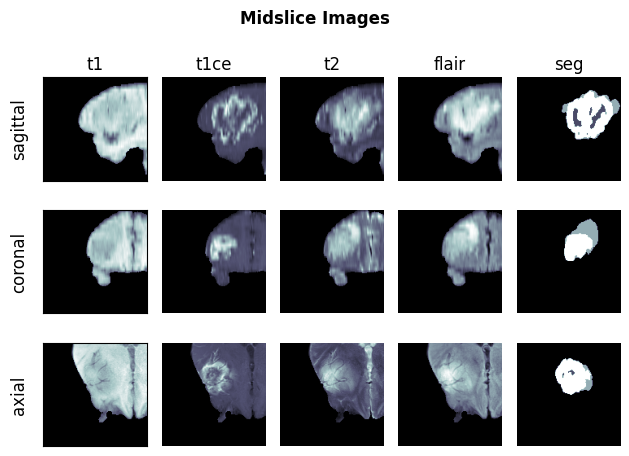

In [19]:
img_train, img_mask = next(iter(train_gen)) #generate batch of training image and mask

#define random patches to be visualized
seed = random.randint(0, 999) 

random.seed(seed)
patch_t1 = img_train[random.randint(0, batch_size-1)][:,:,:,0]

random.seed(seed)
patch_t1ce = img_train[random.randint(0, batch_size-1)][:,:,:,1]

random.seed(seed)
patch_t2 = img_train[random.randint(0, batch_size-1)][:,:,:,2]

random.seed(seed)
patch_flair = img_train[random.randint(0, batch_size-1)][:,:,:,3]

random.seed(seed)
img_mask = img_mask[random.randint(0, batch_size-1)] #select random mask patch
patch_seg = np.argmax(img_mask, axis = 3) #reverse to pre-one-hot encoded form

#visualize random patches
plot_mri(patch_t1, patch_t1ce, patch_t2, patch_flair, patch_seg)

---

## Loss and Metrics

### Dice Coefficient
The Dice coefficient, also known as the Sørensen–Dice coefficient or Dice similarity coefficient, is a statistical measure commonly used to quantify the similarity between two sets. It's often used in the field of image segmentation and medical image analysis to evaluate the performance of segmentation algorithms.

The Dice coefficient is calculated as follows:

> Dice Coefficient = $ \LARGE \frac{2 * |A \cap B|}{|A| + |B|} $

Where:

- A is the first set (e.g., the ground truth segmentation mask or binary image).
- B is the second set (e.g., the predicted segmentation mask or binary image).
- |A| represents the cardinality (number of elements) of set A.
- |B| represents the cardinality (number of elements) of set B.
- |A ∩ B| represents the cardinality of the intersection of sets A and B.

The Dice coefficient ranges from 0 to 1, where 0 signifies no overlap between sets (complete dissimilarity), and 1 signifies complete overlap (total similarity). In image segmentation, a higher Dice coefficient denotes a better match between the ground truth and the predicted segmentation. This metric is particularly valuable for assessing binary segmentation tasks, where the goal is to partition an image into two classes (e.g., foreground and background). Its significance is even more pronounced when class sizes are uneven, as it emphasizes overlap between areas of interest rather than their absolute sizes.

In the subsequent code excerpt, we have defined functions to compute dice coefficients for each individual class. Later, we will take the average of these dice coefficients to get the mean dice coefficient score.

In [20]:
from tensorflow.keras import backend as K

# dice coefficient for necrotic parts
def dice_coefficient_ncr(y_true, y_pred, axis = (0,1,2), epsilon = 1e-5):
  dice_numerator = 2 * K.sum(y_true[:,:,:,1] * tf.round(y_pred[:,:,:,1]), axis = axis) + epsilon
  dice_denominator = K.sum(y_true[:,:,:,1], axis = axis) + K.sum(tf.round(y_pred[:,:,:,1]), axis = axis) + epsilon
  dice_coefficient_ncr = dice_numerator/dice_denominator
  
  return dice_coefficient_ncr

# dice coefficient for peritumor edamtous/ invaded tissue
def dice_coefficient_ed(y_true, y_pred, axis = (0,1,2), epsilon = 1e-5):
  dice_numerator = 2 * K.sum(y_true[:,:,:,2] * tf.round(y_pred[:,:,:,2]), axis = axis) + epsilon
  dice_denominator = K.sum(y_true[:,:,:,2], axis = axis) + K.sum(tf.round(y_pred[:,:,:,2]), axis = axis) + epsilon
  dice_coefficient_ed = dice_numerator/dice_denominator
  
  return dice_coefficient_ed

# dice coefficient for enhancing tumor
def dice_coefficient_et(y_true, y_pred, axis = (0,1,2), epsilon = 1e-5):
  dice_numerator = 2 * K.sum(y_true[:,:,:,3] * tf.round(y_pred[:,:,:,3]), axis = axis) + epsilon
  dice_denominator = K.sum(y_true[:,:,:,3], axis = axis) + K.sum(tf.round(y_pred[:,:,:,3]), axis = axis) + epsilon
  dice_coefficient_et = dice_numerator/dice_denominator
  
  return dice_coefficient_et

### Jaccard Index/ Intersection over Union (IOU)

Like the dice coefficient, The Jaccard index, also known as the Jaccard similarity coefficient or Intersection over Union (IoU), is another mathematical measure used to quantify the similarity or overlap between two sets.

The Jaccard index is calculated as follows:
> $ \Large J(A,B) = \frac{|A \bigcap B|}{|A \bigcup B|} $

Where:

- A is the first set (e.g., the ground truth segmentation mask or binary image).
- B is the second set (e.g., the predicted segmentation mask or binary image).
- |A ∩ B| represents the cardinality of the intersection of sets A and B.
- |A ∪ B| represents the cardinality of the union of sets A and B.

The Jaccard index yields a value between 0 and 1, where 0 signifies no overlap (complete dissimilarity), and 1 signifies perfect overlap (complete similarity) between the two sets. In the context of image segmentation or object detection, a higher Jaccard index indicates a better alignment between the predicted and actual regions.  It provides a dependable way to measure the accuracy and quality of predictions or segmentations, especially when dealing with imbalanced class sizes or evaluating the performance of algorithms that detect specific patterns within larger datasets.

This metric can be defined in the following function:

In [21]:
# mean IOU
def IOU(y_true, y_pred, axis = (0,1,2), epsilon = 1e-5):
    IOU_numerator = K.sum(y_true * K.round(y_pred), axis = axis) + epsilon
    IOU_denominator = K.sum(y_true, axis = axis) + K.sum(K.round(y_pred), axis = axis) - IOU_numerator + epsilon
    IOU = K.mean(IOU_numerator[1:])/K.mean(IOU_denominator[1:]) #ignore void class
    
    return IOU

The Jaccard index was not included in our model's training phase as it was only incorporated afterward in hindsight, once the training had concluded. Nonetheless, this metric will be integrated into the testing phase.

### Soft Dice Loss
Although the Dice Coefficient holds intuitive significance, it is not optimal for training purposes.

The reason for this lies in its reliance on discrete values (zeros and ones).
Given that the model generates probabilities indicating the likelihood of each pixel being associated with a tumor or not, we necessitate the ability to perform backpropagation through these outputs.
As a result, an alternative to the Dice loss that accommodates continuous input values is needed. This is where the concept of the Soft Dice loss becomes relevant.
The soft dice loss is formulated using the following equation:

> $ \LARGE \mathscr{L}_{Dice}(p,q) = 1\ -\ \frac{1}{C}\, \sum_{c=1}^{c}\, \frac{2\ *\ \sum_{ij}\, p_{ij}q_{ij}\ +\ \epsilon}{\sum_{ij}\, p^2_{ij}\ +\ \sum_{ij}\, q^2_{ij}\ + \ \epsilon} $

Where:
- _p_ is our predictions
- _q_ is our ground truth
- In practice each _qi_ will either be 0 or 1
- $\epsilon$ is a small number that is added to avoid division by zero
- _C_ represents the number of classes

The soft Dice Loss ranges between 
- 0: perfectly matching the ground truth distribution _q_
- 1: complete mismatch with the ground truth

Reference: </br>
Rajpurkar, P., Uyumazturk, B., Kiani, A. & Shyu, E. (n.d.) _AI for Medical Diagnosis_[MOOC]. Coursera. </br>
[https://www.coursera.org/learn/ai-for-medical-diagnosis](https://www.coursera.org/learn/ai-for-medical-diagnosis)


In [22]:
# define soft dice loss function
def soft_dice_loss(y_true, y_pred, axis = (0,1,2), epsilon = 1e-5):
  dice_numerator = 2 * K.sum(y_pred * y_true, axis = axis) + epsilon
  dice_denominator = K.sum(y_pred**2, axis = axis) + K.sum(y_true**2, axis = axis) + epsilon
  dice_loss = 1 - K.mean(dice_numerator/dice_denominator) # mean across all channels
  
  return dice_loss

---

## Unet Model Architecture
The U-Net architecture is a convolutional neural network (CNN) architecture that was specifically designed for semantic image segmentation tasks. It was proposed by Olaf Ronneberger, Philipp Fischer, and Thomas Brox in their 2015 paper titled "[U-Net: Convolutional Networks for Biomedical Image Segmentation.](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28)" The U-Net architecture is widely used in medical image analysis, particularly in tasks such as cell segmentation, organ segmentation, and more (Ronnerberger, Fischer, & Brox, 2015).

The U-Net architecture comprises three distinct components: 
1. __The contracting path__</br>
The contracting path is the initial part of the U-Net architecture that is responsible for capturing context and reducing spatial dimensions. It performs feature extraction and context aggregation by progressively applying convolutional layers and downsampling operations.
</br>

2. __Expansive path__</br>
The expansive path follows the contracting path and aims to recover spatial information while performing pixel-wise classification. This path is responsible for producing segmentation maps that match the original image dimensions. 
</br>

3. __Concatenation__ </br>
Concatenation is a key operation that connects the contracting path and the expansive path, facilitating the fusion of contextual information with spatial details. Concatenation enables the network to leverage information from different levels of abstraction.

The figure below is an overview of the original 2D U-net architecture

In [23]:
from IPython.display import Image
# Diagram of the original 2D Unet architecture
print('Source: Ronneberger, Fischer & Brox (2015)')
Image(url= "https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png", width=700)

Source: Ronneberger, Fischer & Brox (2015)


Since our U-Net model deals with 3D images, we've adapted the original architecture by replacing 2D convolutional, max-pooling, and transpose convolutional layers with their 3D counterparts. Furthermore, to match our intended input dimensions, we've introduced padding in specific layers. To enhance regularization, a dropout rate of 0.3 has been implemented across all layers within both the contracting and expansion paths.

In [24]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, Dropout
from keras.optimizers import Adam

def unet(input_size = (128, 128, 128, 4), num_classes = 4, kernel_initializer = 'he_normal'):
#Build the model
    inputs = Input(input_size)

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(inputs)
    c1 = Dropout(0.2)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.2)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3) 
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4) 
     
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.2)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    
    #Expansive path 
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5) 
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6) 
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7) 
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7) 
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8) 
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9) 
    c9 = Dropout(0.2)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
    outputs = Conv3D(num_classes, (1, 1, 1), activation = 'softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #compile
    model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
    loss = soft_dice_loss,
    metrics = [IOU, dice_coefficient_ncr, dice_coefficient_ed, dice_coefficient_et])
    
    model.summary()

    return model

#Test if everything is working ok. 
model = unet()
print(model.input_shape)
print(model.output_shape)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 128, 4)]   0         []                            
                                                                                                  
 conv3d (Conv3D)             (None, 128, 128, 128, 16)    1744      ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 128, 128, 128, 16)    0         ['conv3d[0][0]']              
                                                                                                  
 conv3d_1 (Conv3D)           (None, 128, 128, 128, 16)    6928      ['dropout[0][0]']             
                                                                                              

---

## Training the Model

Due to the size the dataset and complexity of the model, training it will be very time consuming. Hence, I've partitioned the training into smaller and more manageable episodes.

In [25]:
import math
steps_per_epoch = math.ceil(len(os.listdir(train_x_path))/batch_size) 
validation_steps = math.ceil(len(os.listdir(val_x_path))/batch_size)

In [25]:
#train
history = model.fit(
  train_gen, 
  validation_data = val_gen,
  epochs = 2,
  steps_per_epoch = steps_per_epoch,
  validation_steps = validation_steps)

Epoch 1/2


232/232 [==============================] - 32719s 141s/step - loss: 0.6949 - IOU: 0.6504 - dice_coefficient_ncr: 0.6242 - dice_coefficient_ed: 0.6330 - dice_coefficient_et: 0.5534 - val_loss: 0.6322 - val_IOU: 0.8234 - val_dice_coefficient_ncr: 0.8686 - val_dice_coefficient_ed: 0.7938 - val_dice_coefficient_et: 0.7730
Epoch 2/2
232/232 [==============================] - 32926s 142s/step - loss: 0.5933 - IOU: 0.8921 - dice_coefficient_ncr: 0.5972 - dice_coefficient_ed: 0.5524 - dice_coefficient_et: 0.5075 - val_loss: 0.5844 - val_IOU: 0.8693 - val_dice_coefficient_ncr: 0.6099 - val_dice_coefficient_ed: 0.5623 - val_dice_coefficient_et: 0.5353


In [26]:
import pickle

'''
#save the weights
model.save_weights(os.path.join(brats_saved, 'hist_weights'))

# save history
with open(os.path.join(brats_saved, 'history'), 'wb') as f:
    pickle.dump(history.history, f)
'''

"\n#save the weights\nmodel.save_weights(os.path.join(brats_saved, 'hist_weights'))\n\n# save history\nwith open(os.path.join(brats_saved, 'history'), 'wb') as f:\n    pickle.dump(history.history, f)\n"

In [27]:
#restore weights
model.load_weights(os.path.join(brats_saved, 'hist_weights'))

#load history
with open(os.path.join(brats_saved, 'history'), 'rb') as f:
    history = pickle.load(f)

In [43]:
#train
history2 = model.fit(
  train_gen, 
  validation_data = val_gen,
  epochs = 3,
  initial_epoch = 2,
  steps_per_epoch = steps_per_epoch,
  validation_steps = validation_steps)

Epoch 3/3
232/232 [==============================] - 34032s 147s/step - loss: 0.5604 - IOU: 0.9089 - dice_coefficient_ncr: 0.6274 - dice_coefficient_ed: 0.5859 - dice_coefficient_et: 0.5853 - val_loss: 0.5687 - val_IOU: 0.8575 - val_dice_coefficient_ncr: 0.5304 - val_dice_coefficient_ed: 0.4873 - val_dice_coefficient_et: 0.4671


In [46]:
'''
#save the weights
model.save_weights(os.path.join(brats_saved, 'hist_weights2'))

# save history
with open(os.path.join(brats_saved, 'history2'), 'wb') as f:
    pickle.dump(history2.history, f)
'''

In [28]:
#restore weights2
model.load_weights(os.path.join(brats_saved, 'hist_weights2'))

#load history2
with open(os.path.join(brats_saved, 'history2'), 'rb') as f:
    history2 = pickle.load(f)

In [77]:
#train
history3 = model.fit(
  train_gen, 
  validation_data = val_gen,
  epochs = 5,
  initial_epoch = 3,
  steps_per_epoch = steps_per_epoch,
  validation_steps = validation_steps)

Epoch 4/5
232/232 [==============================] - 33851s 146s/step - loss: 0.5067 - IOU: 0.9425 - dice_coefficient_ncr: 0.7445 - dice_coefficient_ed: 0.7461 - dice_coefficient_et: 0.7395 - val_loss: 0.5050 - val_IOU: 0.9354 - val_dice_coefficient_ncr: 0.8291 - val_dice_coefficient_ed: 0.7971 - val_dice_coefficient_et: 0.7942
Epoch 5/5
232/232 [==============================] - 34529s 149s/step - loss: 0.4741 - IOU: 0.9527 - dice_coefficient_ncr: 0.8360 - dice_coefficient_ed: 0.8357 - dice_coefficient_et: 0.8381 - val_loss: 0.4987 - val_IOU: 0.9135 - val_dice_coefficient_ncr: 0.8260 - val_dice_coefficient_ed: 0.8286 - val_dice_coefficient_et: 0.8203


In [84]:
'''
#save the weights
model.save_weights(os.path.join(brats_saved, 'hist_weights3'))

# save history
with open(os.path.join(brats_saved, 'history3'), 'wb') as f:
    pickle.dump(history3.history, f)
'''

In [29]:
#restore weights3
model.load_weights(os.path.join(brats_saved, 'hist_weights3'))

#load history3
with open(os.path.join(brats_saved, 'history3'), 'rb') as f:
    history3 = pickle.load(f)

In [72]:
#compile
model.compile(
optimizer = tf.keras.optimizers.Adam(learning_rate = 5e-5), #half learning_rate
loss = soft_dice_loss,
metrics = [IOU, dice_coefficient_ncr, dice_coefficient_ed, dice_coefficient_et])

In [ ]:
#train
history4 = model.fit(
  train_gen, 
  validation_data = val_gen,
  epochs = 7,
  initial_epoch = 5,
  steps_per_epoch = steps_per_epoch,
  validation_steps = validation_steps)

In [44]:
'''
#save the weights
model.save_weights(os.path.join(brats_saved, 'hist_weights4'))

# save history
with open(os.path.join(brats_saved, 'history4'), 'wb') as f:
    pickle.dump(history4.history, f)
'''

In [73]:
#restore weights4
model.load_weights(os.path.join(brats_saved, 'hist_weights4'))

#load history4
with open(os.path.join(brats_saved, 'history4'), 'rb') as f:
    history4 = pickle.load(f)

In [59]:
#train
history5 = model.fit(
  train_gen, 
  validation_data = val_gen,
  epochs = 10,
  initial_epoch = 7,
  steps_per_epoch = steps_per_epoch,
  validation_steps = validation_steps)

Epoch 8/10


232/232 [==============================] - 22967s 99s/step - loss: 0.2713 - IOU: 0.9608 - dice_coefficient_ncr: 0.9656 - dice_coefficient_ed: 0.9622 - dice_coefficient_et: 0.9530 - val_loss: 0.3163 - val_IOU: 0.9370 - val_dice_coefficient_ncr: 0.9611 - val_dice_coefficient_ed: 0.9654 - val_dice_coefficient_et: 0.9664
Epoch 9/10
232/232 [==============================] - 23156s 100s/step - loss: 0.2567 - IOU: 0.9626 - dice_coefficient_ncr: 0.9679 - dice_coefficient_ed: 0.9639 - dice_coefficient_et: 0.9539 - val_loss: 0.2919 - val_IOU: 0.9484 - val_dice_coefficient_ncr: 0.9549 - val_dice_coefficient_ed: 0.9538 - val_dice_coefficient_et: 0.9641
Epoch 10/10
232/232 [==============================] - 23162s 100s/step - loss: 0.2434 - IOU: 0.9640 - dice_coefficient_ncr: 0.9687 - dice_coefficient_ed: 0.9644 - dice_coefficient_et: 0.9558 - val_loss: 0.3001 - val_IOU: 0.9423 - val_dice_coefficient_ncr: 0.9534 - val_dice_coefficient_ed: 0.9569 - val_dice_coefficient_et: 0.9471


In [63]:
'''
#save the weights
model.save_weights(os.path.join(brats_saved, 'hist_weights5'))

# save history
with open(os.path.join(brats_saved, 'history5'), 'wb') as f:
    pickle.dump(history5.history, f)
'''

In [84]:
#restore weights
model.load_weights(os.path.join(brats_saved, 'hist_weights5'))

#load history
with open(os.path.join(brats_saved, 'history5'), 'rb') as f:
    history5 = pickle.load(f)

### Combine Histories from Multiple Training Episodes

In [102]:
# concat loss histories
loss_concat = history['loss'] + history2['loss'] + history3['loss'] + history4['loss'] + history5['loss']
val_loss_concat = history['val_loss'] + history2['val_loss'] + history3['val_loss'] + history4['val_loss'] + history5['val_loss']

# concat IOU histories
IOU_concat = history['IOU'] + history2['IOU'] + history3['IOU'] + history4['IOU'] + history5['IOU']
val_IOU_concat = history['val_IOU'] + history2['val_IOU'] + history3['val_IOU'] + history4['val_IOU'] + history5['val_IOU']

#concat dice_coefficient histories
dice_coefficient_ed_concat = history['dice_coefficient_ed'] + \
                             history2['dice_coefficient_ed'] + \
                             history3['dice_coefficient_ed'] + \
                             history4['dice_coefficient_ed'] + \
                             history5['dice_coefficient_ed']
                             
val_dice_coefficient_ed_concat = history['val_dice_coefficient_ed'] + \
                                 history2['val_dice_coefficient_ed'] + \
                                 history3['val_dice_coefficient_ed'] + \
                                 history4['val_dice_coefficient_ed'] + \
                                 history5['val_dice_coefficient_ed']
                                 
dice_coefficient_et_concat = history['dice_coefficient_et'] + \
                             history2['dice_coefficient_et'] + \
                             history3['dice_coefficient_et'] + \
                             history4['dice_coefficient_et'] + \
                             history5['dice_coefficient_et']
                             
val_dice_coefficient_et_concat = history['val_dice_coefficient_et'] + \
                                 history2['val_dice_coefficient_et'] + \
                                 history3['val_dice_coefficient_et'] + \
                                 history4['val_dice_coefficient_et'] + \
                                 history5['val_dice_coefficient_et']
                                 
dice_coefficient_ncr_concat = history['dice_coefficient_ncr'] + \
                             history2['dice_coefficient_ncr'] + \
                             history3['dice_coefficient_ncr'] + \
                             history4['dice_coefficient_ncr'] + \
                             history5['dice_coefficient_ncr']
                             
val_dice_coefficient_ncr_concat = history['val_dice_coefficient_ncr'] + \
                                 history2['val_dice_coefficient_ncr'] + \
                                 history3['val_dice_coefficient_ncr'] + \
                                 history4['val_dice_coefficient_ncr'] + \
                                 history5['val_dice_coefficient_ncr']
        
# get mean dice coefficient                               
dice_coefficient_concat_mean = (np.array(dice_coefficient_ed_concat) + np.array(dice_coefficient_et_concat) + np.array(dice_coefficient_ncr_concat))/3
val_dice_coefficient_concat_mean = (np.array(val_dice_coefficient_ed_concat) + np.array(val_dice_coefficient_et_concat) + np.array(val_dice_coefficient_ncr_concat))/3


### Plot Learning Curves

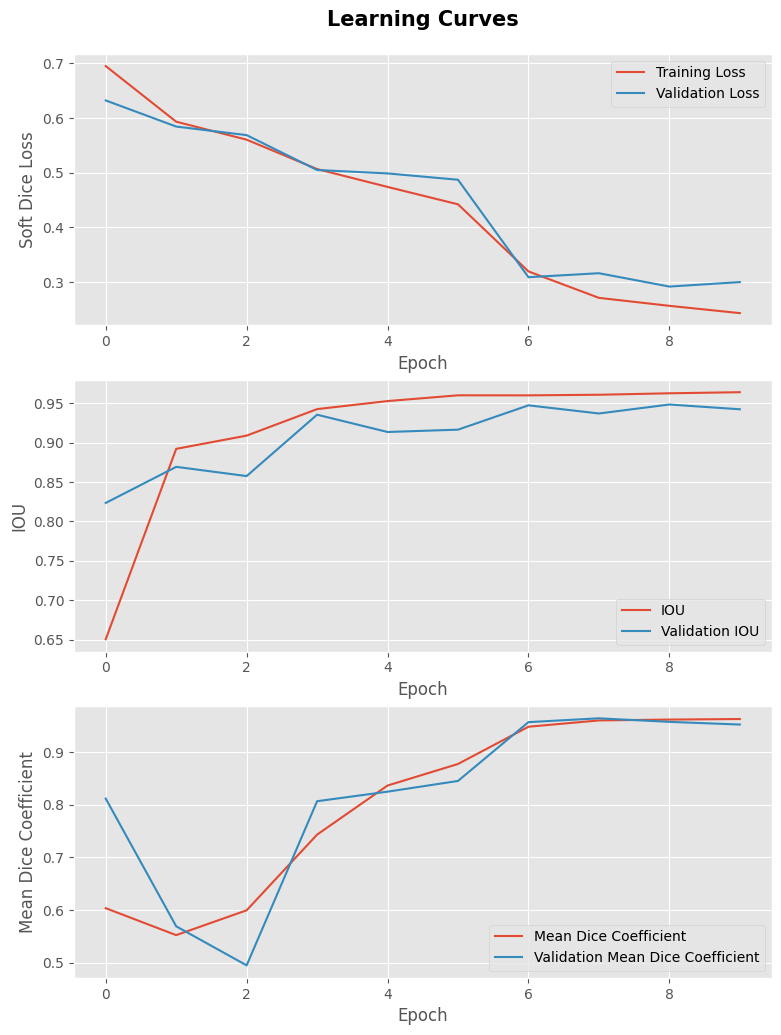

In [103]:
#plot learning curves
plt.figure(figsize = (9,12))
plt.style.use('ggplot')

#plot loss
plt.subplot(3, 1, 1)
plt.plot(loss_concat, label = 'Training Loss')
plt.plot(val_loss_concat, label = 'Validation Loss')
plt.ylabel('Soft Dice Loss')
plt.xlabel('Epoch')
plt.legend(loc = 'upper right')
plt.title('Learning Curves', pad = 20, fontsize = 15, fontweight = 'bold')

#plot IOU
plt.subplot(3,1,2)
plt.plot(IOU_concat, label = 'IOU')
plt.plot(val_IOU_concat, label = 'Validation IOU')
plt.ylabel('IOU')
plt.xlabel('Epoch')
plt.legend(loc = 'lower right')

#plot dice coefficient
plt.subplot(3,1,3)
plt.plot(dice_coefficient_concat_mean, label = 'Mean Dice Coefficient')
plt.plot(val_dice_coefficient_concat_mean, label = 'Validation Mean Dice Coefficient')
plt.ylabel('Mean Dice Coefficient')
plt.xlabel('Epoch')
plt.legend(loc = 'lower right')


---

## Test on Whole Images

Before testing our model on the whole image, I've modified our mri visualization function by adding a column to display the predicted segments. This allows us to visually compare our predictions against the ground truth.

### Modify plotting function to include predicted segments

In [81]:
#define a function to plot midslice MRI test images
def plot_mri_test(image_t1, image_t1ce, image_t2, image_flair, image_seg, pred_seg):
  plt.close()
  plt.figure(figsize = (12,12))
  fig, axes = plt.subplots(3,6)

  #t1
  axes[0,0].imshow(ndimage.rotate(image_t1[image_t1.shape[0]//2,:,:], 90), cmap = 'bone')
  axes[0,0].grid(False)
  axes[1,0].imshow(ndimage.rotate(image_t1[:,image_t1.shape[1]//2,:], 90), cmap = 'bone')
  axes[1,0].grid(False)
  axes[2,0].imshow(ndimage.rotate(image_t1[:,:,image_t1.shape[2]//2], 90), cmap = 'bone')
  axes[2,0].grid(False)
  
  #t1ce
  axes[0,1].imshow(ndimage.rotate(image_t1ce[image_t1ce.shape[0]//2,:,:], 90), cmap = 'bone')
  axes[0,1].axis('off')
  axes[1,1].imshow(ndimage.rotate(image_t1ce[:,image_t1ce.shape[1]//2,:], 90), cmap = 'bone')
  axes[1,1].axis('off')
  axes[2,1].imshow(ndimage.rotate(image_t1ce[:,:,image_t1ce.shape[2]//2], 90), cmap = 'bone')
  axes[2,1].axis('off')
  
  #t2
  axes[0,2].imshow(ndimage.rotate(image_t2[image_t2.shape[0]//2,:,:], 90), cmap = 'bone')
  axes[0,2].axis('off')
  axes[1,2].imshow(ndimage.rotate(image_t2[:,image_t2.shape[1]//2,:], 90), cmap = 'bone')
  axes[1,2].axis('off')
  axes[2,2].imshow(ndimage.rotate(image_t2[:,:,image_t2.shape[2]//2], 90), cmap = 'bone')
  axes[2,2].axis('off')
  
  #flair
  axes[0,3].imshow(ndimage.rotate(image_flair[image_flair.shape[0]//2,:,:], 90), cmap = 'bone')
  axes[0,3].axis('off')
  axes[1,3].imshow(ndimage.rotate(image_flair[:,image_flair.shape[1]//2,:], 90), cmap = 'bone')
  axes[1,3].axis('off')
  axes[2,3].imshow(ndimage.rotate(image_flair[:,:,image_flair.shape[2]//2], 90), cmap = 'bone')
  axes[2,3].axis('off')
  
  #seg
  axes[0,4].imshow(ndimage.rotate(image_seg[image_seg.shape[0]//2,:,:], 90), cmap = 'bone')
  axes[0,4].axis('off')
  axes[1,4].imshow(ndimage.rotate(image_seg[:,image_seg.shape[1]//2,:], 90), cmap = 'bone')
  axes[1,4].axis('off')
  axes[2,4].imshow(ndimage.rotate(image_seg[:,:,image_seg.shape[2]//2], 90), cmap = 'bone')
  axes[2,4].axis('off')
  
  #pred
  axes[0,5].imshow(ndimage.rotate(pred_seg[pred_seg.shape[0]//2,:,:], 90), cmap = 'bone')
  axes[0,5].axis('off')
  axes[1,5].imshow(ndimage.rotate(pred_seg[:,pred_seg.shape[1]//2,:], 90), cmap = 'bone')
  axes[1,5].axis('off')
  axes[2,5].imshow(ndimage.rotate(pred_seg[:,:,pred_seg.shape[2]//2], 90), cmap = 'bone')
  axes[2,5].axis('off')
  
  #col and row labels
  cols = ['t1', 't1ce', 't2', 'flair', 'seg', 'pred']
  rows = ['sagittal', 'coronal', 'axial']
  
  for ax, col in zip(axes[0], cols):
    ax.set_title(col)
    
  for ax, row in zip(axes[:,0], rows):
    ax.tick_params(left = False, bottom = False)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.set_ylabel(row, rotation=90, size = 'large')
  
  fig.suptitle('Midslice Images', fontweight = 'bold')
  fig.tight_layout()
  plt.show()

### Define Function to Perform Patch Based Segmentation

The code below defines the function to evaluate the predictive performance of our model on the whole image. I hypothesize that patches close to the centre of the image are more valuable than those at the edges because it contains greater amounts of contextual information to make better predictions. Hence, a weighting feature was added to the defined function to test this hypothesis.
This function performs the following steps:

For every test image:
1. Create an empty matrix of dimensions equivalent to that of the whole image
2. obtain predictions from individual patches
3. Add predictions to their corresponding voxels on the void matrix created in step 1.
4. Divide the predictions by their weight, including the number of times each voxel was overlapped.
5. Calculate performance metrics for the whole image.

In [153]:
import math
def test_whole_images(image_dims = (240, 240, 155, 4), patch_dims = (128, 128, 128, 4), steps = (112, 112, 27), inner_steps = (56,56,15), mid_multiplier = 20, inner_multiplier = 10):
    
    #create list of metrics
    dice_coefficient_ncr_list = []
    dice_coefficient_ed_list = []
    dice_coefficient_et_list = []
    IOU_list = []
    
    #define starting points for middle patch
    mid_width_start = int((image_dims[0] - patch_dims[0])/2 -1) 
    mid_height_start = math.ceil((image_dims[2] - patch_dims[2])/2) -1
    
    #define starting and end points for inner patches
    inner_width_start = int((orig_dims[0] - output_dims[0])/4) -1
    inner_height_start = (orig_dims[2] - output_dims[2])//4 -1
    
    for i, image in enumerate(sorted(os.listdir(test_x_path))):
        pred_whole = np.zeros(image_dims)
        tracking_channel = np.expand_dims(np.zeros(image_dims[:-1]), axis = 3)
        plt_whole = np.zeros((240, 240, 155, 5))
        tracker = np.expand_dims(np.ones(patch_dims[:-1]), axis = 3)
        pred_whole = np.concatenate((pred_whole, tracking_channel), axis = 3) # add tracking channel to whole image
        
        #load all patches for each image
        x_000 = tf.data.Dataset.from_tensors(np.load(os.path.join(test_x_path, image, image + '_000.npy'))).batch(batch_size = 1)
        x_001 = tf.data.Dataset.from_tensors(np.load(os.path.join(test_x_path, image, image + '_001.npy'))).batch(batch_size = 1)
        x_010 = tf.data.Dataset.from_tensors(np.load(os.path.join(test_x_path, image, image + '_010.npy'))).batch(batch_size = 1)
        x_011 = tf.data.Dataset.from_tensors(np.load(os.path.join(test_x_path, image, image + '_011.npy'))).batch(batch_size = 1)
        x_100 = tf.data.Dataset.from_tensors(np.load(os.path.join(test_x_path, image, image + '_100.npy'))).batch(batch_size = 1)
        x_101 = tf.data.Dataset.from_tensors(np.load(os.path.join(test_x_path, image, image + '_101.npy'))).batch(batch_size = 1)
        x_110 = tf.data.Dataset.from_tensors(np.load(os.path.join(test_x_path, image, image + '_110.npy'))).batch(batch_size = 1)
        x_111 = tf.data.Dataset.from_tensors(np.load(os.path.join(test_x_path, image, image + '_111.npy'))).batch(batch_size = 1)
        
        x_inner000 = tf.data.Dataset.from_tensors(np.load(os.path.join(test_x_path, image, image + '_inner000.npy'))).batch(batch_size = 1)
        x_inner001 = tf.data.Dataset.from_tensors(np.load(os.path.join(test_x_path, image, image + '_inner001.npy'))).batch(batch_size = 1)
        x_inner010 = tf.data.Dataset.from_tensors(np.load(os.path.join(test_x_path, image, image + '_inner010.npy'))).batch(batch_size = 1)
        x_inner011 = tf.data.Dataset.from_tensors(np.load(os.path.join(test_x_path, image, image + '_inner011.npy'))).batch(batch_size = 1)
        x_inner100 = tf.data.Dataset.from_tensors(np.load(os.path.join(test_x_path, image, image + '_inner100.npy'))).batch(batch_size = 1)
        x_inner101 = tf.data.Dataset.from_tensors(np.load(os.path.join(test_x_path, image, image + '_inner101.npy'))).batch(batch_size = 1)
        x_inner110 = tf.data.Dataset.from_tensors(np.load(os.path.join(test_x_path, image, image + '_inner110.npy'))).batch(batch_size = 1)
        x_inner111 = tf.data.Dataset.from_tensors(np.load(os.path.join(test_x_path, image, image + '_inner111.npy'))).batch(batch_size = 1)
        
        x_mid = tf.data.Dataset.from_tensors(np.load(os.path.join(test_x_path, image, image + '_mid.npy'))).batch(batch_size = 1)
        
        #load patches for plotting reconstructed image and add tracker
        x_000_plt = np.concatenate((np.load(os.path.join(test_x_path, image, image + '_000.npy')), tracker), axis = 3)
        x_001_plt = np.concatenate((np.load(os.path.join(test_x_path, image, image + '_001.npy')), tracker), axis = 3)
        x_010_plt = np.concatenate((np.load(os.path.join(test_x_path, image, image + '_010.npy')), tracker), axis = 3)
        x_011_plt = np.concatenate((np.load(os.path.join(test_x_path, image, image + '_011.npy')), tracker), axis = 3)
        x_100_plt = np.concatenate((np.load(os.path.join(test_x_path, image, image + '_100.npy')), tracker), axis = 3)
        x_101_plt = np.concatenate((np.load(os.path.join(test_x_path, image, image + '_101.npy')), tracker), axis = 3)
        x_110_plt = np.concatenate((np.load(os.path.join(test_x_path, image, image + '_110.npy')), tracker), axis = 3)
        x_111_plt = np.concatenate((np.load(os.path.join(test_x_path, image, image + '_111.npy')), tracker), axis = 3)
        
        x_inner000_plt = np.concatenate((np.load(os.path.join(test_x_path, image, image + '_inner000.npy')), tracker), axis = 3)
        x_inner001_plt = np.concatenate((np.load(os.path.join(test_x_path, image, image + '_inner001.npy')), tracker), axis = 3)
        x_inner010_plt = np.concatenate((np.load(os.path.join(test_x_path, image, image + '_inner010.npy')), tracker), axis = 3)
        x_inner011_plt = np.concatenate((np.load(os.path.join(test_x_path, image, image + '_inner011.npy')), tracker), axis = 3)
        x_inner100_plt = np.concatenate((np.load(os.path.join(test_x_path, image, image + '_inner100.npy')), tracker), axis = 3)
        x_inner101_plt = np.concatenate((np.load(os.path.join(test_x_path, image, image + '_inner101.npy')), tracker), axis = 3)
        x_inner110_plt = np.concatenate((np.load(os.path.join(test_x_path, image, image + '_inner110.npy')), tracker), axis = 3)
        x_inner111_plt = np.concatenate((np.load(os.path.join(test_x_path, image, image + '_inner111.npy')), tracker), axis = 3)
        
        x_mid_plt = np.concatenate((np.load(os.path.join(test_x_path, image, image + '_mid.npy')), tracker), axis = 3)
        
        #generate predictions for each patch and add tracker
        x_000_pred = np.concatenate((np.squeeze(model.predict(x_000, verbose = 0)), tracker), axis = 3)
        x_001_pred = np.concatenate((np.squeeze(model.predict(x_001, verbose = 0)), tracker), axis = 3)
        x_010_pred = np.concatenate((np.squeeze(model.predict(x_010, verbose = 0)), tracker), axis = 3)
        x_011_pred = np.concatenate((np.squeeze(model.predict(x_011, verbose = 0)), tracker), axis = 3)
        x_100_pred = np.concatenate((np.squeeze(model.predict(x_100, verbose = 0)), tracker), axis = 3)
        x_101_pred = np.concatenate((np.squeeze(model.predict(x_101, verbose = 0)), tracker), axis = 3)
        x_110_pred = np.concatenate((np.squeeze(model.predict(x_110, verbose = 0)), tracker), axis = 3)
        x_111_pred = np.concatenate((np.squeeze(model.predict(x_111, verbose = 0)), tracker), axis = 3)
        
        x_inner000_pred = np.concatenate((np.squeeze(model.predict(x_inner000, verbose = 0)), tracker), axis = 3) *inner_multiplier
        x_inner001_pred = np.concatenate((np.squeeze(model.predict(x_inner001, verbose = 0)), tracker), axis = 3) *inner_multiplier
        x_inner010_pred = np.concatenate((np.squeeze(model.predict(x_inner010, verbose = 0)), tracker), axis = 3) *inner_multiplier
        x_inner011_pred = np.concatenate((np.squeeze(model.predict(x_inner011, verbose = 0)), tracker), axis = 3) *inner_multiplier
        x_inner100_pred = np.concatenate((np.squeeze(model.predict(x_inner100, verbose = 0)), tracker), axis = 3) *inner_multiplier
        x_inner101_pred = np.concatenate((np.squeeze(model.predict(x_inner101, verbose = 0)), tracker), axis = 3) *inner_multiplier
        x_inner110_pred = np.concatenate((np.squeeze(model.predict(x_inner110, verbose = 0)), tracker), axis = 3) *inner_multiplier
        x_inner111_pred = np.concatenate((np.squeeze(model.predict(x_inner111, verbose = 0)), tracker), axis = 3) *inner_multiplier
        
        x_mid_pred = np.concatenate((np.squeeze(model.predict(x_mid, verbose = 0)), tracker), axis = 3)* mid_multiplier
        
        # add pred patches to whole image
        pred_whole[:patch_dims[0], :patch_dims[1], :patch_dims[2], :] += x_000_pred
        pred_whole[:patch_dims[0], :patch_dims[1], steps[2]: steps[2] + patch_dims[2], :] += x_001_pred
        pred_whole[:patch_dims[0], steps[1]: steps[1] + patch_dims[1], :patch_dims[2], :] += x_010_pred
        pred_whole[:patch_dims[0], steps[1]: steps[1] + patch_dims[1], steps[2]: steps[2] + patch_dims[2], :] += x_011_pred
        pred_whole[steps[0]: steps[0] + patch_dims[0], :patch_dims[1], :patch_dims[2], :] += x_100_pred
        pred_whole[steps[0]: steps[0] + patch_dims[0], :patch_dims[1], steps[2]: steps[2] + patch_dims[2], :] += x_101_pred
        pred_whole[steps[0]: steps[0] + patch_dims[0], steps[1]: steps[1] + patch_dims[1], :patch_dims[2], :] += x_110_pred
        pred_whole[steps[0]: steps[0] + patch_dims[0], steps[1]: steps[1] + patch_dims[1], steps[2]: steps[2] + patch_dims[2], :] += x_111_pred
        pred_whole[mid_width_start: mid_width_start + patch_dims[0], 
                   mid_width_start: mid_width_start + patch_dims[1], 
                   mid_height_start: mid_height_start + patch_dims[2],
                   :] += x_mid_pred
        
        pred_whole[inner_width_start: inner_width_start + patch_dims[0],
                   inner_width_start: inner_width_start + patch_dims[1],
                   inner_height_start: inner_height_start + patch_dims[2],
                   :] += x_inner000_pred
        
        pred_whole[inner_width_start: inner_width_start + patch_dims[0],
                   inner_width_start: inner_width_start + patch_dims[1],
                   inner_height_start + inner_steps[2]: inner_height_start + inner_steps[2] + patch_dims[2],
                   :] += x_inner001_pred
        
        pred_whole[inner_width_start: inner_width_start + patch_dims[0],
                   inner_width_start + inner_steps[1]: inner_width_start + inner_steps[1] + patch_dims[1],
                   inner_height_start: inner_height_start + patch_dims[2],
                   :] += x_inner010_pred
        
        pred_whole[inner_width_start: inner_width_start + patch_dims[0],
                   inner_width_start + inner_steps[1]: inner_width_start + inner_steps[1] + patch_dims[1],
                   inner_height_start + inner_steps[2]: inner_height_start + inner_steps[2] + patch_dims[2],
                   :] += x_inner011_pred
        
        pred_whole[inner_width_start + inner_steps[0]: inner_width_start + inner_steps[0] + patch_dims[0],
                   inner_width_start: inner_width_start + patch_dims[1],
                   inner_height_start: inner_height_start + patch_dims[2],
                   :] += x_inner100_pred
        
        pred_whole[inner_width_start + inner_steps[0]: inner_width_start + inner_steps[0] + patch_dims[0],
                   inner_width_start: inner_width_start + patch_dims[1],
                   inner_height_start + inner_steps[2]: inner_height_start + inner_steps[2] + patch_dims[2],
                   :] += x_inner101_pred
        
        pred_whole[inner_width_start + inner_steps[0]: inner_width_start + inner_steps[0] + patch_dims[0],
                   inner_width_start + inner_steps[1]: inner_width_start + inner_steps[1] + patch_dims[1],
                   inner_height_start: inner_height_start + patch_dims[2],
                   :] += x_inner110_pred
        
        pred_whole[inner_width_start + inner_steps[0]: inner_width_start + inner_steps[0] + patch_dims[0],
                   inner_width_start + inner_steps[1]: inner_width_start + inner_steps[1] + patch_dims[1],
                   inner_height_start + inner_steps[2]: inner_height_start + + inner_steps[2] + patch_dims[2],
                   :] += x_inner111_pred
        
        #reconstruct patches for plotting
        plt_whole[:patch_dims[0], :patch_dims[1], :patch_dims[2], :] += x_000_plt
        plt_whole[:patch_dims[0], :patch_dims[1], steps[2]: steps[2] + patch_dims[2], :] += x_001_plt
        plt_whole[:patch_dims[0], steps[1]: steps[1] + patch_dims[1], :patch_dims[2], :] += x_010_plt
        plt_whole[:patch_dims[0], steps[1]: steps[1] + patch_dims[1], steps[2]: steps[2] + patch_dims[2], :] += x_011_plt
        plt_whole[steps[0]: steps[0] + patch_dims[0], :patch_dims[1], :patch_dims[2], :] += x_100_plt
        plt_whole[steps[0]: steps[0] + patch_dims[0], :patch_dims[1], steps[2]: steps[2] + patch_dims[2], :] += x_101_plt
        plt_whole[steps[0]: steps[0] + patch_dims[0], steps[1]: steps[1] + patch_dims[1], :patch_dims[2], :] += x_110_plt
        plt_whole[steps[0]: steps[0] + patch_dims[0], steps[1]: steps[1] + patch_dims[1], steps[2]: steps[2] + patch_dims[2], :] += x_111_plt
        plt_whole[mid_width_start: mid_width_start + patch_dims[0], 
                   mid_width_start: mid_width_start + patch_dims[1], 
                   mid_height_start: mid_height_start + patch_dims[2],
                   :] += x_mid_plt
        
        
        plt_whole[inner_width_start: inner_width_start + patch_dims[0],
                   inner_width_start: inner_width_start + patch_dims[1],
                   inner_height_start: inner_height_start + patch_dims[2],
                   :] += x_inner000_plt
        
        plt_whole[inner_width_start: inner_width_start + patch_dims[0],
                   inner_width_start: inner_width_start + patch_dims[1],
                   inner_height_start + inner_steps[2]: inner_height_start + inner_steps[2] + patch_dims[2],
                   :] += x_inner001_plt
        
        plt_whole[inner_width_start: inner_width_start + patch_dims[0],
                   inner_width_start + inner_steps[1]: inner_width_start + inner_steps[1] + patch_dims[1],
                   inner_height_start: inner_height_start + patch_dims[2],
                   :] += x_inner010_plt
        
        plt_whole[inner_width_start: inner_width_start + patch_dims[0],
                   inner_width_start + inner_steps[1]: inner_width_start + inner_steps[1] + patch_dims[1],
                   inner_height_start + inner_steps[2]: inner_height_start + inner_steps[2] + patch_dims[2],
                   :] += x_inner011_plt
        
        plt_whole[inner_width_start + inner_steps[0]: inner_width_start + inner_steps[0] + patch_dims[0],
                   inner_width_start: inner_width_start + patch_dims[1],
                   inner_height_start: inner_height_start + patch_dims[2],
                   :] += x_inner100_plt
        
        plt_whole[inner_width_start + inner_steps[0]: inner_width_start + inner_steps[0] + patch_dims[0],
                   inner_width_start: inner_width_start + patch_dims[1],
                   inner_height_start + inner_steps[2]: inner_height_start + inner_steps[2] + patch_dims[2],
                   :] += x_inner101_plt
        
        plt_whole[inner_width_start + inner_steps[0]: inner_width_start + inner_steps[0] + patch_dims[0],
                   inner_width_start + inner_steps[1]: inner_width_start + inner_steps[1] + patch_dims[1],
                   inner_height_start: inner_height_start + patch_dims[2],
                   :] += x_inner110_plt
        
        plt_whole[inner_width_start + inner_steps[0]: inner_width_start + inner_steps[0] + patch_dims[0],
                   inner_width_start + inner_steps[1]: inner_width_start + inner_steps[1] + patch_dims[1],
                   inner_height_start + inner_steps[2]: inner_height_start + + inner_steps[2] + patch_dims[2],
                   :] += x_inner111_plt
        
        #divide overlapping portions
        y_pred = pred_whole[:,:,:,:-1]/ np.expand_dims(pred_whole[:,:,:,-1], axis = 3)
        y_pred = np.float32(y_pred)
        
        #divide overlapping portions for plot
        img_plt = plt_whole[:,:,:,:-1]/ np.expand_dims(plt_whole[:,:,:,-1], axis = 3)
        
        #load ground truth
        y_file = sorted(os.listdir(test_y_path))[i]
        y_true = np.load(os.path.join(test_y_path, y_file))
                
        #plot reconstructed image
        y_true_plt = np.argmax(y_true, axis = 3) #reverse one hot encoding for plotting
        y_pred_plt = np.argmax(y_pred, axis = 3)
        t1_plt = img_plt[:,:,:,0]
        t1ce_plt = img_plt[:,:,:,1]
        t2_plt = img_plt[:,:,:,2]
        flair_plt = img_plt[:,:,:,3]
        
        plot_mri_test(t1_plt, t1ce_plt, t2_plt, flair_plt, y_true_plt, y_pred_plt)
        
        # compute metrics
        dice_coefficient_ncr_list.append(dice_coefficient_ncr(y_true, y_pred))
        dice_coefficient_ed_list.append(dice_coefficient_ed(y_true, y_pred))
        dice_coefficient_et_list.append(dice_coefficient_et(y_true, y_pred))
        IOU_list.append(IOU(y_true, y_pred))
        
    return(dice_coefficient_ncr_list, dice_coefficient_ed_list, dice_coefficient_et_list, IOU_list)

### Generate Predictions of Whole Images

In [ ]:
dice_coefficient_ncr_list0, dice_coefficient_ed_list0, dice_coefficient_et_list0, IOU_list0 = test_whole_images(mid_multiplier = 0, inner_multiplier = 0)
dice_coefficient_ncr_list1, dice_coefficient_ed_list1, dice_coefficient_et_list1, IOU_list1 = test_whole_images(mid_multiplier = 20, inner_multiplier = 10)

---

## Evaluate Model Performance on Whole Images

### Visualize Distribution of IOU and Dice Coefficient Scores across Test Images

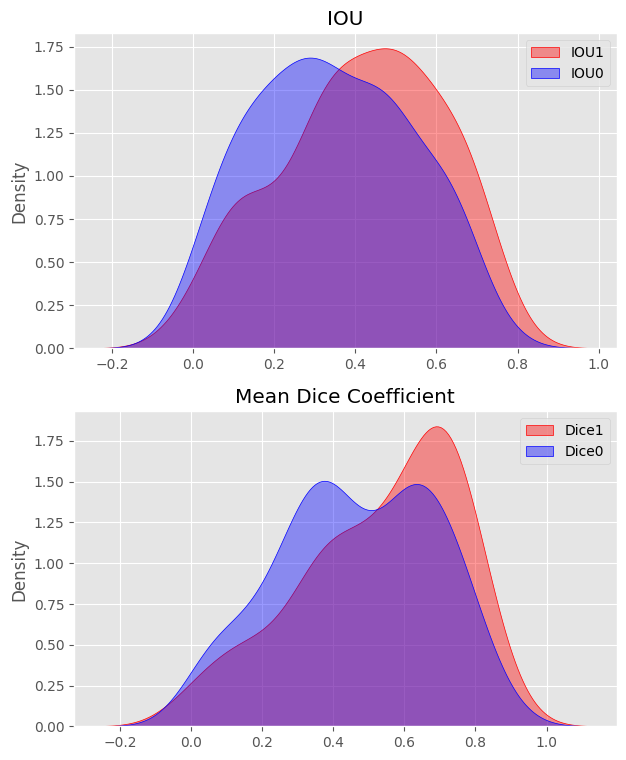

In [215]:
dice_coefficient_mean_list1 = (np.array(dice_coefficient_et_list1) + \
    np.array(dice_coefficient_ed_list1) + \
    np.array(dice_coefficient_ncr_list1))/3

dice_coefficient_mean_list0 = (np.array(dice_coefficient_et_list0) + \
    np.array(dice_coefficient_ed_list0) + \
    np.array(dice_coefficient_ncr_list0))/3

import seaborn as sns
plt.figure(figsize = (7,9))
plt.subplot(2,1,1)
sns.kdeplot(np.array(IOU_list1), color = 'red', fill = 'red', alpha = 0.4).set(title = 'IOU')
sns.kdeplot(np.array(IOU_list0), color = 'blue', fill = 'blue', alpha = 0.4)
plt.legend(['IOU1', 'IOU0'])

plt.subplot(2,1,2)

sns.kdeplot(x = dice_coefficient_mean_list1, color = 'red', fill = 'red', alpha = 0.4).set(title = 'Mean Dice Coefficient')
sns.kdeplot(x = dice_coefficient_mean_list0, color = 'blue', fill = 'blue', alpha = 0.4)
plt.legend(['Dice1', 'Dice0'])

From the above plots we can already see that including weighted central images generally produced better predictions. Lets confirm this hypothesis with a t-test.

## Hypothesis Testing with Paired t-test

To test our hypothesis, we compare the predictive performance of our model with and without weighted central patches.

**Null hypothesis:** </br>
There is no difference in IOU or Dice Coefficient between predictions produced by the two methods.

**Alternative hypothesis:** </br>
There is a significant difference in IOU or Dice Coefficient between predictions generated from the two methods.

In [182]:
#perform paired sample ttest
from scipy import stats

#compare IOUs
print(stats.ttest_rel(np.array(IOU_list1), np.array(IOU_list0)))

#compare mean dice coefficient
print(stats.ttest_rel(dice_coefficient_mean_list1, dice_coefficient_mean_list0))

TtestResult(statistic=12.288285506329778, pvalue=1.2458723124705965e-21, df=99)
TtestResult(statistic=10.353208482122213, pvalue=1.8578262738369197e-17, df=99)


## Conclusions

In this project, we have performed patch-based 3D segmentation of MRI brain images. The predictive accuracy of our model and whole images was inconsistent, generating predictions that resembled the ground truth in some examples, but not in others. Overall, the model seemed to overpredict and tended to generate more false positives. To further test this observation, an evaluation of sensitivity and specificity is warranted, and enhancements in prediction quality may be achieved through fine-tuning prediction thresholds.

While patch-wise validation of the model initially showed promising results, the performance of the model on whole images was ultimately unsatisfactory. This discrepancy in outcomes could potentially be attributed to variances in the patch characteristics between the validation and test datasets:

1. The validation set incorporated patches with a predetermined threshold proportion of positively classified voxels, a criterion absent in the testing set.
2. Patch extraction for validation was random across the entire image, whereas the test set patches were extracted from fixed coordinates.

To obtain better performance of the model on whole images, one viable approach might be to train it on patches extracted from the same positions as those within the test set. Furthermore, one can also consider relaxing the threshold to permit patches with less positively classed patches, or remove this threshold altogether.

### Model's Metrics on Whole Images

In [184]:
#Report predictive performance of the model
print('=== Metrics ===')
print(f'IOU: {np.mean(np.array(IOU_list1))}')
print(f'Mean Dice Coefficient: {np.mean(dice_coefficient_mean_list1)}')
print(f'Dice Coefficient et: {np.mean(np.array(dice_coefficient_et_list1))}')
print(f'Dice Coefficient ed: {np.mean(np.array(dice_coefficient_ed_list1))}')
print(f'Dice Coefficient ncr: {np.mean(np.array(dice_coefficient_ncr_list1))}')

=== Metrics ===
IOU: 0.4134324789047241
Mean Dice Coefficient: 0.529965341091156
Dice Coefficient et: 0.6196314692497253
Dice Coefficient ed: 0.5083915591239929
Dice Coefficient ncr: 0.46187302470207214


---

## References
1. U.Baid, et al., The RSNA-ASNR-MICCAI BraTS 2021 Benchmark on Brain Tumor Segmentation and Radiogenomic Classification, arXiv:2107.02314, 2021.

2. Rajpurkar, P., Uyumazturk, B., Kiani, A. & Shyu, E. (n.d.) _AI for Medical Diagnosis_[MOOC]. Coursera. [https://www.coursera.org/learn/ai-for-medical-diagnosis](https://www.coursera.org/learn/ai-for-medical-diagnosis)

3. Ronneberger, O., Fischer, P., & Brox, T. (2015). U-net: Convolutional networks for biomedical image segmentation. In Medical Image Computing and Computer-Assisted Intervention–MICCAI 2015: 18th International Conference, Munich, Germany, October 5-9, 2015, Proceedings, Part III 18 (pp. 234-241). Springer International Publishing.